### 7.0. Libraries

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
#NLP
from textblob import TextBlob
#Random Forest model -> subervised learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math 
#Visualization of Random Forest
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization

### 7.1. Reade the file (books and movie in one file)

In [161]:
df = pd.read_excel(r'C:\Users\AnjaF\Desktop\My_final_project\files\Step_6_join_bestseller_books_with_films\bestseller_books_movies_by_hand.xlsx')

In [162]:
df.head()

,Unnamed: 0,Author,Name,Genre,Year,Rating,Reviews,Price,Book_into_Movie
0,0,David Baldacci,Zero Day,fiction,2011,4.5,7657.0,14.67,0
1,1,Reza Aslan,Zealot,nonfiction,2013,4.4,6352.0,7.89,0
2,2,Amy Poehler,Yes Please,nonfiction,2014,4.3,4487.0,22.25,0
3,3,Nora Roberts,Year One,fiction,2017,4.6,9358.0,8.83,0
4,4,Sue Grafton,X,fiction,2015,4.4,6071.0,7.04,0


In [163]:
df = df.drop_duplicates()

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588 entries, 0 to 587
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       588 non-null    int64  
 1   Author           588 non-null    object 
 2   Name             588 non-null    object 
 3   Genre            588 non-null    object 
 4   Year             588 non-null    int64  
 5   Rating           588 non-null    float64
 6   Reviews          588 non-null    float64
 7   Price            588 non-null    float64
 8   Book_into_Movie  588 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 45.9+ KB


In [165]:
df["Book_into_Movie"].value_counts()

0    526
1     62
Name: Book_into_Movie, dtype: int64

In [166]:
df = df.drop(columns=["Unnamed: 0"])

In [167]:
# reset index-> because of drop duplicates
df.reset_index(inplace = True)

### 7.2. Create a new column as AVG (Rating/Reviews)

In [168]:
df["Average"] = df["Rating"]/df["Reviews"]

### 7.3. EDA

Frequency analysis of column:  Author
Frequency analysis of column:  Name
Frequency analysis of column:  Genre


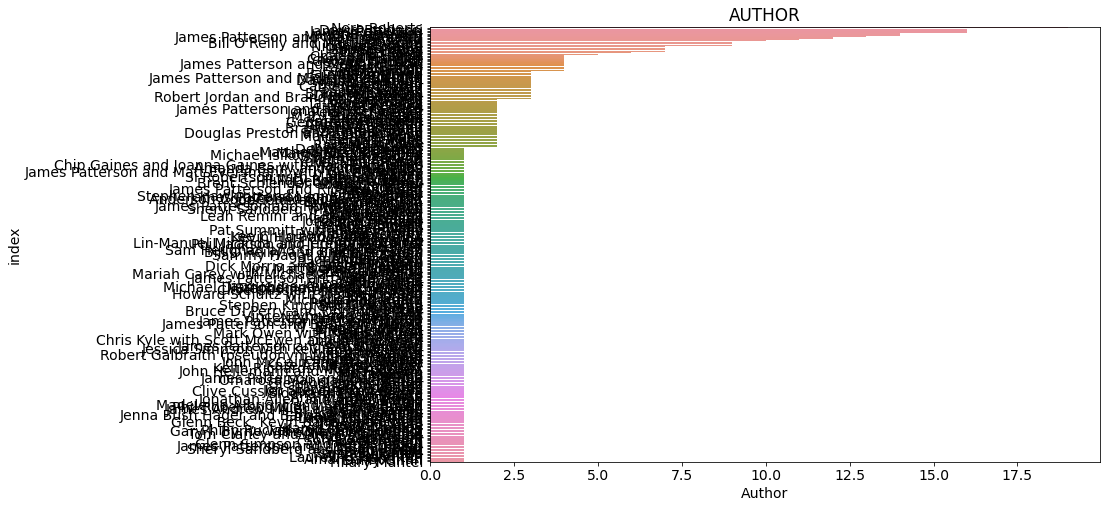

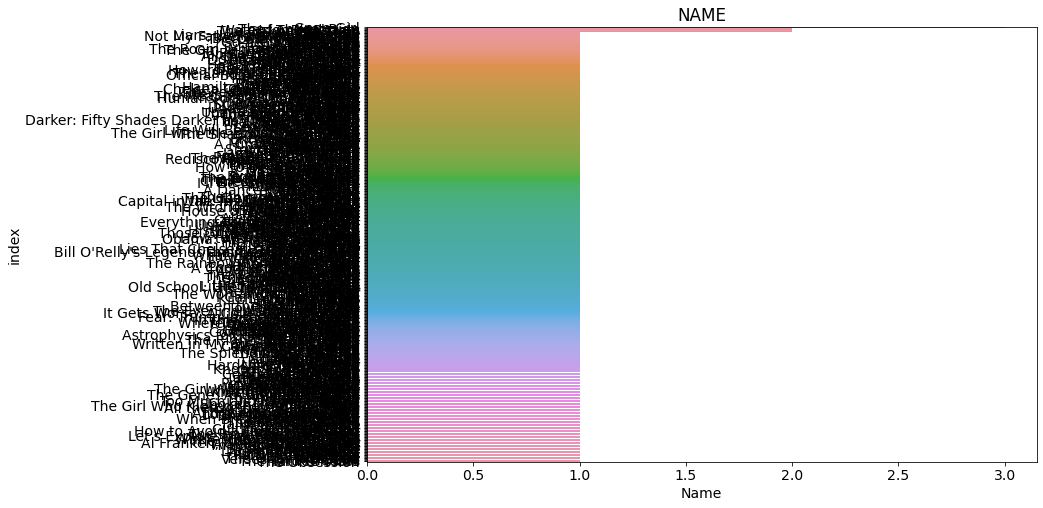

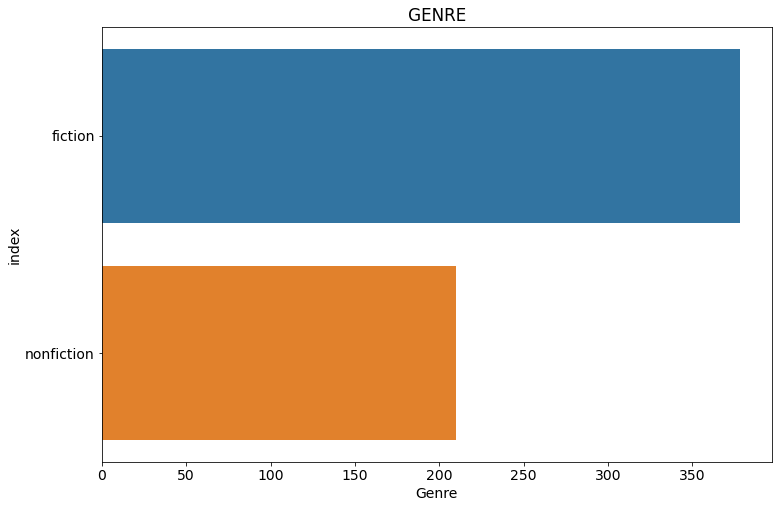

<Figure size 864x576 with 0 Axes>

In [169]:
# show the differetn features in plots to check correlation and distributions

cols_cat = list(df.select_dtypes(include=['object']).columns)

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = df[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

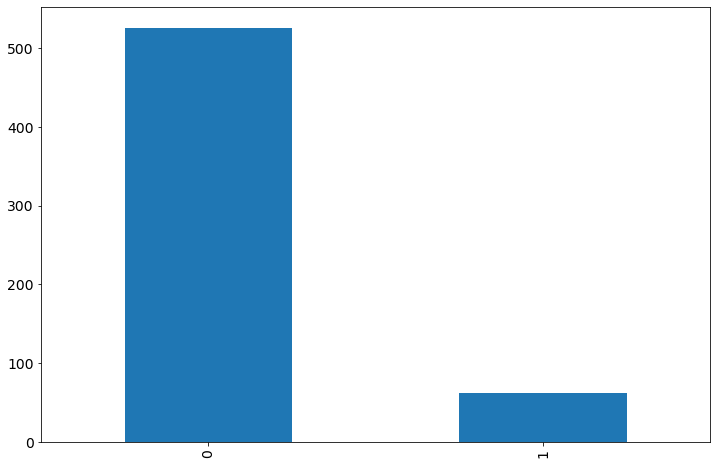

<Figure size 864x576 with 0 Axes>

In [170]:
df["Book_into_Movie"].value_counts().plot(kind="bar")
plt.figure();

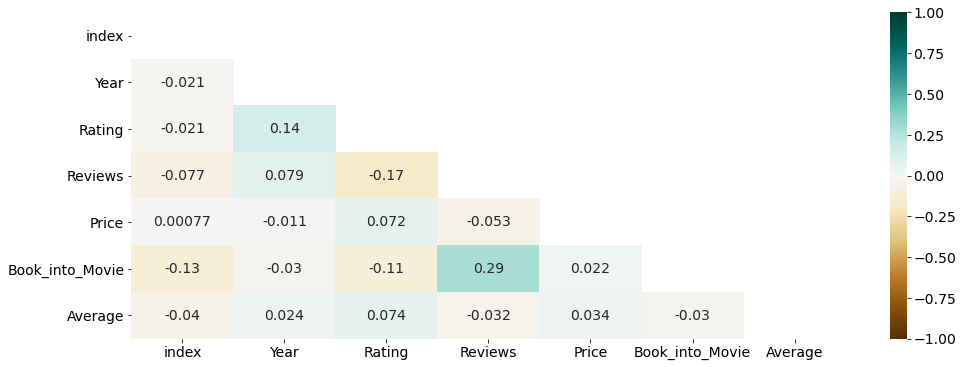

In [171]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [172]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

for column in num_cols:
    print(column, '-->', df['Book_into_Movie'].corr(df[column]))

index --> -0.13163420268544573
Year --> -0.03039243072792773
Rating --> -0.11160916087424004
Reviews --> 0.2856115348791367
Price --> 0.021753381834388307
Book_into_Movie --> 1.0
Average --> -0.02963374983761086


### 7.4. Change the column genre in fiction = 1 and non-fiction = 0

In [173]:
def cleanGenre(x):
    if x == "fiction":
        return 1
    elif x == "nonfiction":
        return 0
    else:
        return 'unknown'
df['Genre'] = list(map(cleanGenre, df['Genre']))

In [174]:
# check the result
df["Genre"].value_counts()

1    378
0    210
Name: Genre, dtype: int64

### 7.5. Apply the NLP on the book title (unfortunatly no critics/reviews available) 

In [175]:
def NLP(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

In [176]:
df['Polarity'] = df['Name'].apply(NLP).apply(lambda x: x[0])
df['Subjectivity'] = df['Name'].apply(NLP).apply(lambda x: x[1])

In [177]:
# check the results
df.head()

,index,Author,Name,Genre,Year,Rating,Reviews,Price,Book_into_Movie,Average,Polarity,Subjectivity
0,0,David Baldacci,Zero Day,1,2011,4.5,7657.0,14.67,0,0.000588,0.0,0.0
1,1,Reza Aslan,Zealot,0,2013,4.4,6352.0,7.89,0,0.000693,0.0,0.0
2,2,Amy Poehler,Yes Please,0,2014,4.3,4487.0,22.25,0,0.000958,0.0,0.0
3,3,Nora Roberts,Year One,1,2017,4.6,9358.0,8.83,0,0.000492,0.0,0.0
4,4,Sue Grafton,X,1,2015,4.4,6071.0,7.04,0,0.000725,0.0,0.0


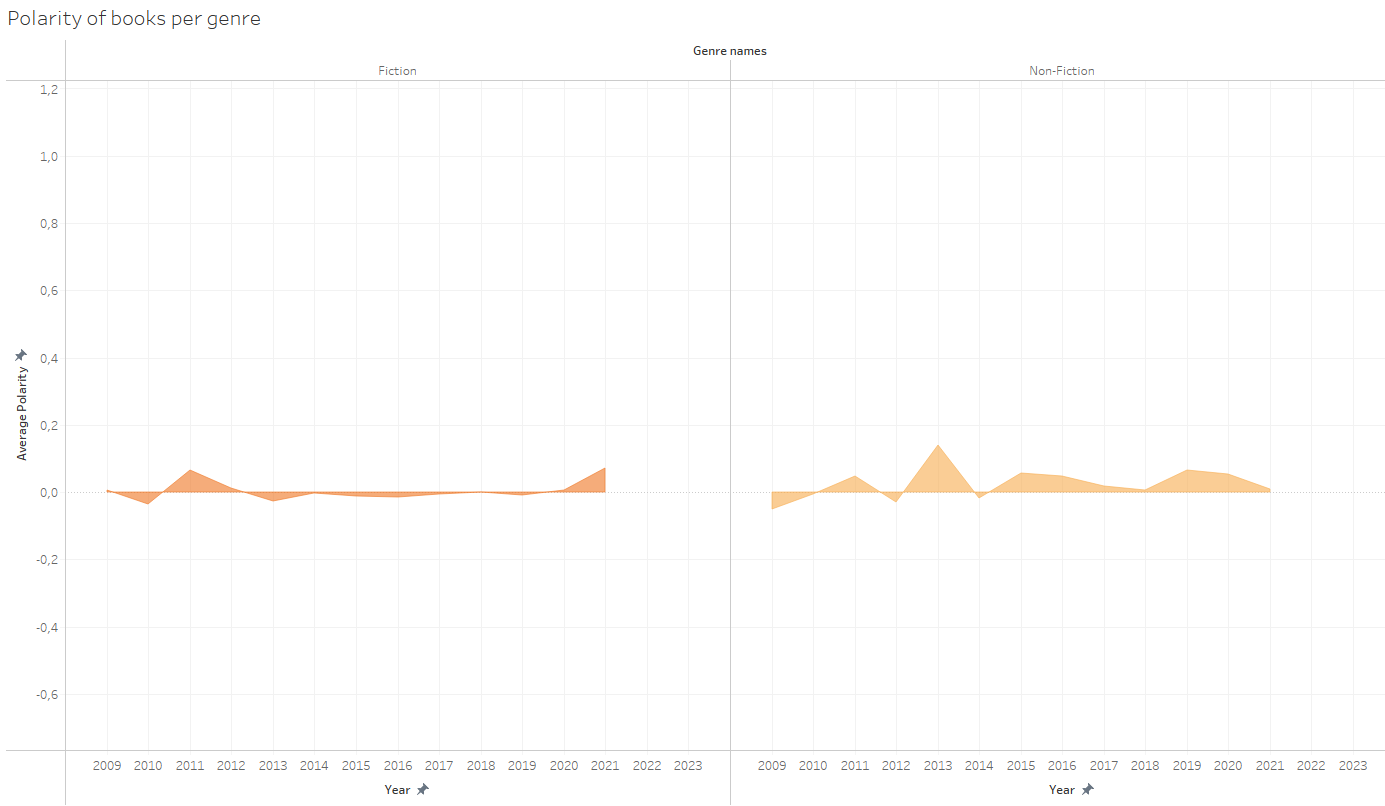

### 7.6. Apply Random Forest model (first time)

In [178]:
# between column Average and columns Rating and Reviews exist not correlation, 
# although Average is the result from Rating/Reviews
# -> the first apply of the random forest shows that the column Average is not useful -> the float-values are too large

- first apply

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            588 non-null    int64  
 1   Author           588 non-null    object 
 2   Name             588 non-null    object 
 3   Genre            588 non-null    int64  
 4   Year             588 non-null    int64  
 5   Rating           588 non-null    float64
 6   Reviews          588 non-null    float64
 7   Price            588 non-null    float64
 8   Book_into_Movie  588 non-null    int64  
 9   Average          587 non-null    float64
 10  Polarity         588 non-null    float64
 11  Subjectivity     588 non-null    float64
dtypes: float64(6), int64(4), object(2)
memory usage: 55.2+ KB


-> safe the dataset to improve the model

In [180]:
df.to_excel("dataset_random_forest_model.xlsx", index=False)

- *Split the data in "Names" of the book*
- *"Author" of the books
- *the independent variables X*
- *the target variable y (=Book_into_Movie)*

In [181]:
Name = df.Name
Author = df.Author
y= df.Book_into_Movie
X= df.drop(columns=["index", "Author", "Name", "Book_into_Movie", "Average"])

- *Scaling the Data*

In [182]:
# use an other Scaler is a possibility to improve the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- *define Training-dataset and Test-dataset*

In [183]:
# my dataset consist of 580 rows the books which are movies ->corresponds to 10 percent on the whole set
# at first: test size at first 10 %
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=40)

In [184]:
regressor = RandomForestRegressor(n_estimators=10, max_depth=3)
model= regressor.fit(X_train,y_train)  
predictions  = model.predict(X_test)
print('Prediction Random Forest:',predictions)

Prediction Random Forest: [0.46110922 0.03334387 0.11380635 0.04026799 0.42646538 0.04794797
 0.5482817  0.45384973 0.11664112 0.11380635 0.03334387 0.06444725
 0.50405625 0.04794797 0.03334387 0.03334387 0.12881128 0.04026799
 0.04794797 0.04026799 0.17821347 0.05005154 0.04026799 0.54496534
 0.04026799 0.04026799 0.04794797 0.04794797 0.12073047 0.38686671
 0.04026799 0.04026799 0.03334387 0.09882408 0.04026799 0.04026799
 0.04026799 0.46110922 0.04026799 0.03334387 0.1057482  0.20229076
 0.1057482  0.36801381 0.04026799 0.03334387 0.1057482  0.34573176
 0.40870113 0.18968355 0.04026799 0.1057482  0.09184571 0.12073047
 0.04794797 0.03334387 0.04026799 0.11380635 0.35875882]


- compare the values

In [185]:
y_values = pd.DataFrame({"real_values": y_test, "pred_values": predictions})
y_values

,real_values,pred_values
382,0,0.461109
324,0,0.033344
209,0,0.113806
579,0,0.040268
310,0,0.426465
12,0,0.047948
161,1,0.548282
16,1,0.453850
332,0,0.116641
51,0,0.113806


- *Visualization of Decision Tree*

In [186]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [187]:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

RandomForestRegressor(max_depth=3)

In [188]:
plt.figure(figsize=(140,140))
_ = tree.plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)

- *Evaluation*

In [189]:
r= r2_score(y_test, predictions)
print("The R² is: " + str(r))

mse = mean_squared_error(y_test, predictions)
print("The mean squared error is: " + str(mse))

rmse = math.sqrt(mse)
print("The root mean square error is: " + str(mse))

# the results shows a model that is not good

The R² is: 0.09003580217854923
The mean squared error is: 0.07058038879971035
The root mean square error is: 0.07058038879971035


### Apply the dataset for books 2021 on this model

In [190]:
df_2021 = pd.read_excel(r'C:\Users\AnjaF\Desktop\My_final_project\files\Step_7_apply_NLP_and_Random_Forest\dataset_random_forest_model_2021.xlsx')
Name2021 = df_2021.Name
Author2021 = df_2021.Author
y2021 = df_2021.Book_into_Movie
X2021 = df_2021.drop(columns=["Author", "Name", "Book_into_Movie", "index", "Average"])
X2021_scaled = scaler.fit_transform(X2021)
predictions2021  = model.predict(X2021_scaled)
predictions2021

array([0.36598176, 0.04794797, 0.04794797, 0.04794797, 0.04794797,
       0.04794797, 0.04794797, 0.34573176, 0.30245113, 0.04794797,
       0.04026799, 0.04794797, 0.48803945, 0.04026799, 0.04794797,
       0.04794797, 0.04794797, 0.23547099, 0.45198176, 0.12223769,
       0.04794797])

In [191]:
mean_squared_error(y2021, predictions2021, squared = False)

0.23876428208213138

In [192]:
y_values2021 = pd.DataFrame({'Real Values':y2021, 'Predicted Values':predictions2021, 'Name_of_the_book': Name2021})
y_values2021

,Real Values,Predicted Values,Name_of_the_book
0,0,0.365982,Win
1,0,0.047948,What Happened to You?
2,0,0.047948,Walk in My Combat Boots
3,0,0.047948,This Is the Fire
4,0,0.047948,Think Again
5,0,0.047948,The Russian
6,0,0.047948,The Hill We Climb
7,1,0.345732,The Four Winds
8,0,0.302451,The Duke and I
9,0,0.047948,The Code Breaker
